In [1]:

import importlib
import data_prep as dp
import pandas as pd
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [2]:
import matplotlib.pyplot as plt

In [ ]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [183]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv')

In [184]:
df.index = pd.to_datetime(df['date'])

In [185]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock



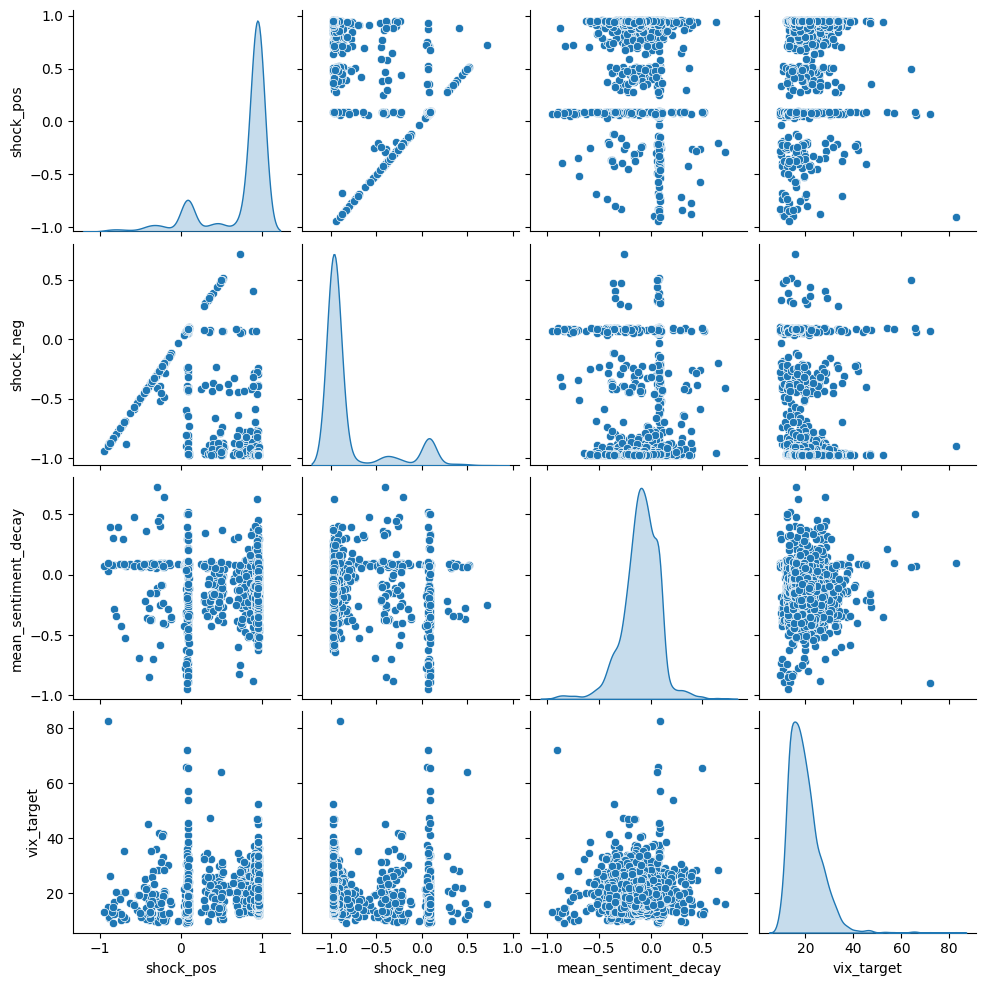

In [186]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [331]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [332]:

train_size = 0.8  # 80% for training
split_idx = int(len(df) * train_size)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Train set: 1564 rows
Test set: 391 rows


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Features: ['shock_neg', 'dominance_trigger']
AIC: 9104.385, LogL: -4543.192
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                 1564
Model:               MarkovRegression   Log Likelihood               -4543.192
Date:                Mon, 14 Apr 2025   AIC                           9104.385
Time:                        14:59:58   BIC                           9152.580
Sample:                             0   HQIC                          9122.302
                               - 1564                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


In [333]:
import numpy as np

P_00 = results.params['p[0->0]']       # P(stay in regime 0)
P_10 = results.params['p[1->0]']       # P(switch from regime 1 to 0)
P_01 = 1 - P_00                       # P(switch from regime 0 to 1)
P_11 = 1 - P_10                       # P(stay in regime 1)

transition_matrix = np.array([
    [P_00, P_01],  # from regime 0
    [P_10, P_11]   # from regime 1
])

print("Transition Matrix:")
print(transition_matrix)





Transition Matrix:
[[0.98895749 0.01104251]
 [0.02459565 0.97540435]]


In [371]:
# Get the most likely regime at each time step
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0)
selected_features = feature_sets[0]


In [372]:
df_model['vix_target_t+1'] = df_model['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction

regime_col = df_model['regime_t'].copy() #so that it doesnt erase

df_model = df_model.dropna(subset=selected_features + ['vix_target_t+1']).copy()

df_model['regime_t'] = regime_col.loc[df_model.index]


X = df_model[selected_features]
y = df_model['vix_target_t+1']

model2 = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results2 = model2.fit() #model for predicting the vix level t+1


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [373]:
print(results2.summary())

                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                 1562
Model:               MarkovRegression   Log Likelihood               -4539.552
Date:                Mon, 14 Apr 2025   AIC                           9097.104
Time:                        15:22:06   BIC                           9145.288
Sample:                             0   HQIC                          9115.018
                               - 1562                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0367      0.268     56.042      0.000      14.511      15.563
x1            -2.3408      0.364     -6.433      0.0

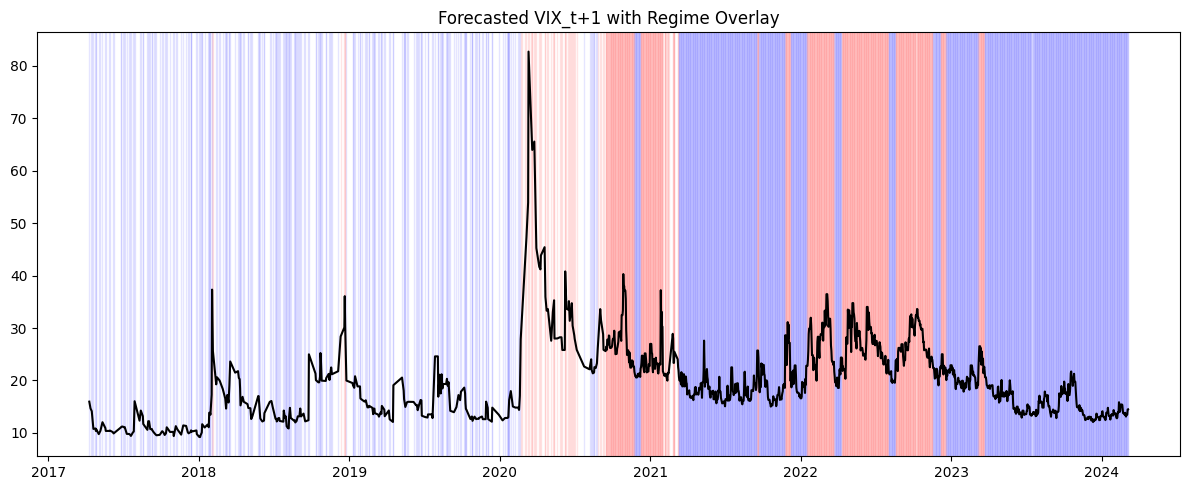

In [374]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i], df_model.index[i], color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [375]:
df_model['regime_t'] = results.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.1 else 0) #regime dataset for t


In [376]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1


In [377]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [378]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
clf.fit(X_cls, y_cls)

# Evaluate
y_pred = clf.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.68      0.98      0.80       991
         1.0       0.88      0.19      0.32       570

    accuracy                           0.70      1561
   macro avg       0.78      0.59      0.56      1561
weighted avg       0.75      0.70      0.63      1561



In [379]:
probs = clf.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


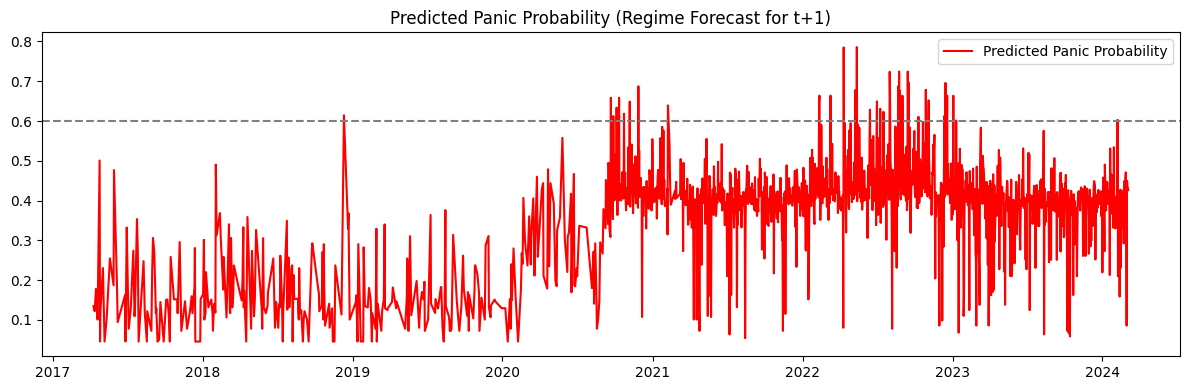

In [380]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


In [381]:


classification_df.index = pd.to_datetime(classification_df.index)


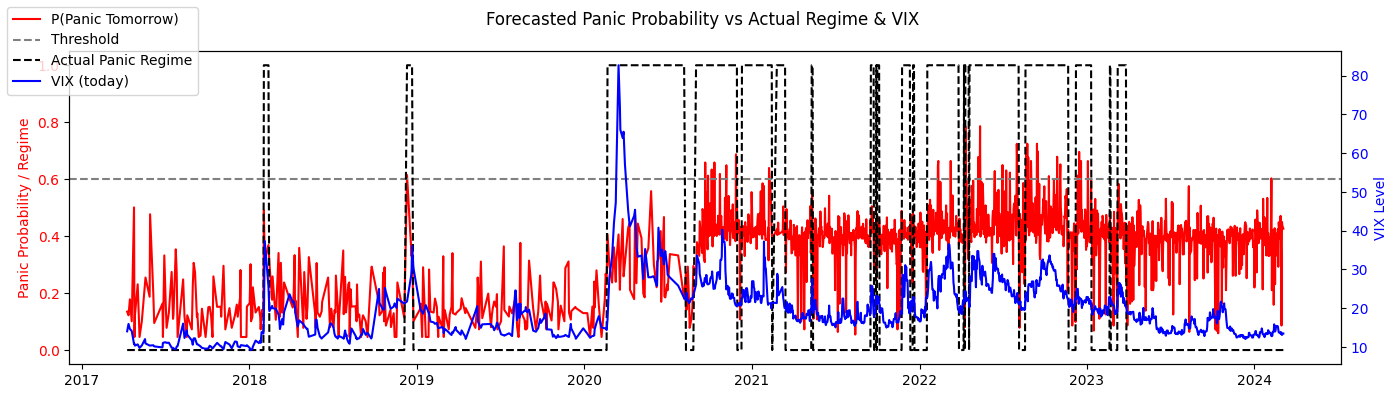

In [382]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


# Test Set on models (regime + panic probability)


In [387]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
test_df = test_df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X_test = test_df[selected_features]
y_test = test_df['vix_target_t+1']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.0015 else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['panic_prob_t+1'] = test_df['panic_prob_t+1'].shift(1)




/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


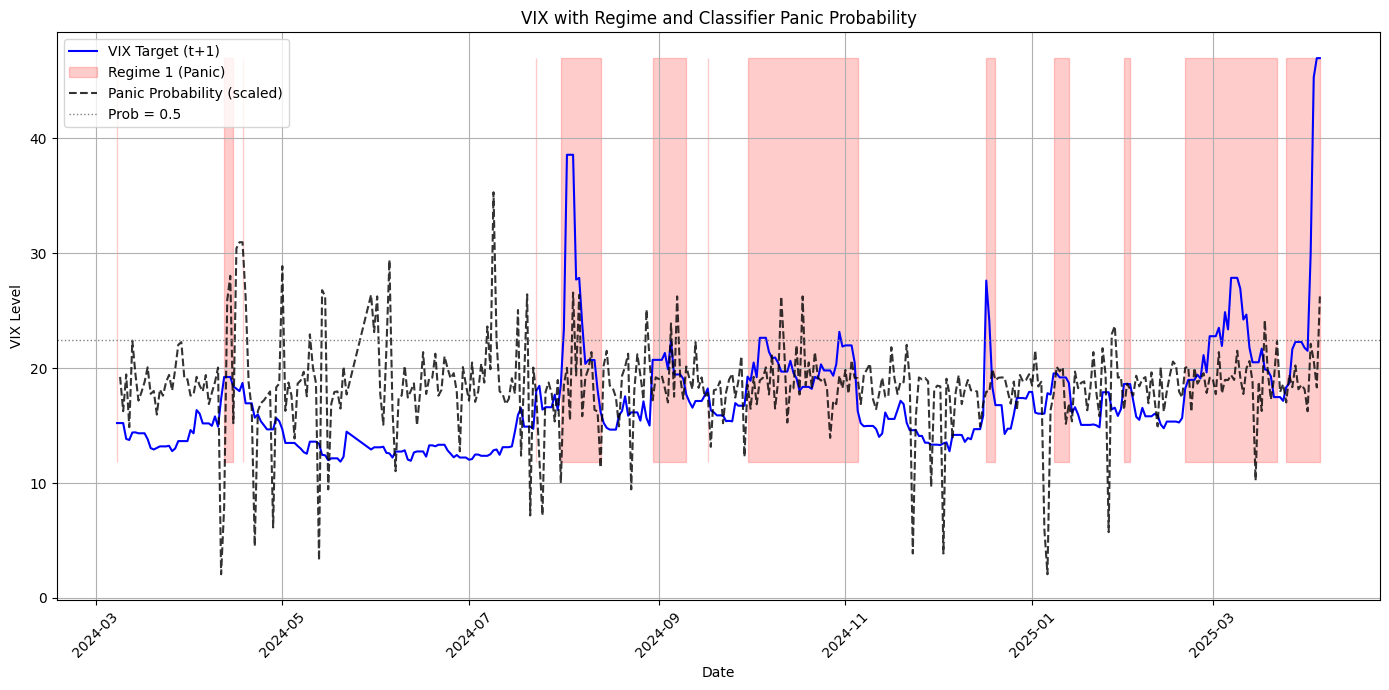

In [388]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Markov Switching Auto Regressive model

In [389]:
regime_0_df = df_model[df_model['regime_t'] == 0]
regime_1_df = df_model[df_model['regime_t'] == 1]

In [390]:
from statsmodels.tsa.ar_model import AutoReg

ar_regime_0 = AutoReg(regime_0_df['vix_target'], lags=1, trend='c').fit()
ar_regime_1 = AutoReg(regime_1_df['vix_target'], lags=1, trend='c').fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [391]:
import numpy as np
def forecast_vix_autoreg(current_vix, current_regime):
    phi = ar_regime_0.params if current_regime == 0 else ar_regime_1.params
    forecast = phi['const'] + phi['vix_target.L1'] * current_vix
    return forecast

In [392]:
sigma_0 = np.std(ar_regime_0.resid)
sigma_1 = np.std(ar_regime_1.resid)

phi_0 = ar_regime_0.params
phi_1 = ar_regime_1.params

transition_matrix_forecast = transition_matrix #from our first model

initial_regime = df_model['regime_t'].iloc[-1]  # last predicted regime


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_75369/2253765997.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_75369/2253765997.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]


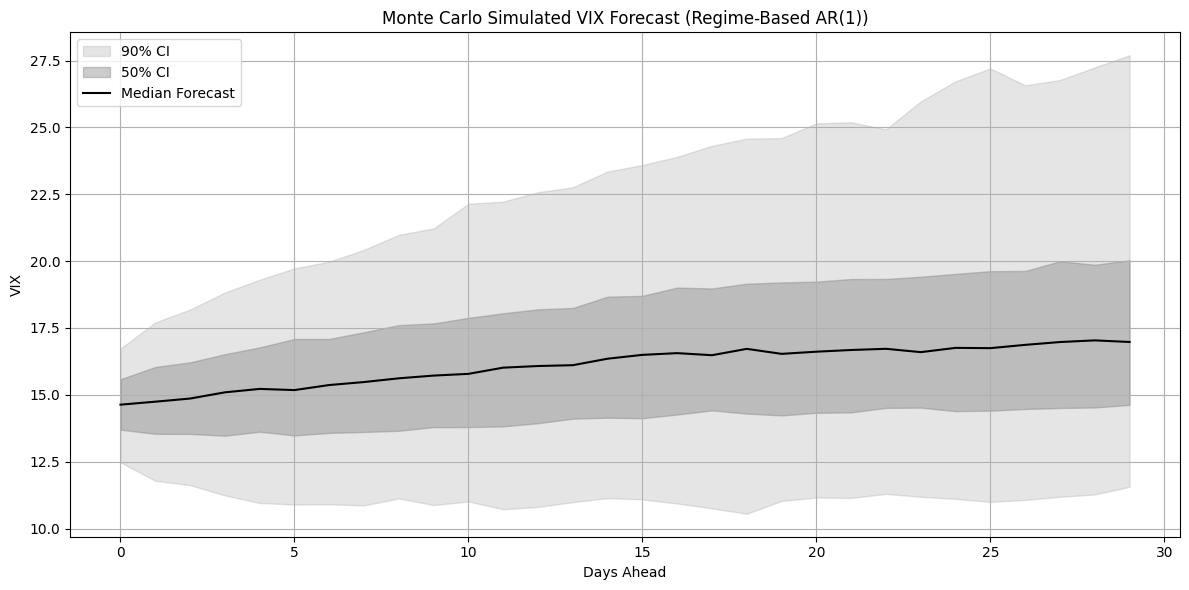

In [393]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vix_paths_ar(n_days=30, n_paths=1000, start_val=20, start_regime=0,
                          phi_0=None, phi_1=None,
                          sigma_0=1.0, sigma_1=1.0,
                          transition_matrix=None):
    paths = np.zeros((n_paths, n_days))
    regimes = np.zeros((n_paths, n_days), dtype=int)

    for i in range(n_paths):
        vix = start_val
        regime = start_regime

        for t in range(n_days):
            # Transition to next regime
            regime = np.random.choice([0, 1], p=transition_matrix[regime])
            regimes[i, t] = regime

            if regime == 0:
                const = phi_0['const']
                phi = phi_0[phi_0.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_0)
                vix = const + phi * vix + shock
            else:
                const = phi_1['const']
                phi = phi_1[phi_1.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_1)
                vix = const + phi * vix + shock

            paths[i, t] = vix

    return paths, regimes

# === Run the simulation ===
start_vix = df_model['vix_target'].iloc[-1]
sim_paths, sim_regimes = simulate_vix_paths_ar(
    n_days=30,
    n_paths=1000,
    start_val=start_vix,
    start_regime=initial_regime,
    phi_0=phi_0,
    phi_1=phi_1,
    sigma_0=sigma_0,
    sigma_1=sigma_1,
    transition_matrix=transition_matrix_forecast
)

# === Plot fan chart ===
percentiles = np.percentile(sim_paths, [5, 25, 50, 75, 95], axis=0)
days = np.arange(sim_paths.shape[1])

plt.figure(figsize=(12, 6))
plt.fill_between(days, percentiles[0], percentiles[-1], color='gray', alpha=0.2, label='90% CI')
plt.fill_between(days, percentiles[1], percentiles[-2], color='gray', alpha=0.4, label='50% CI')
plt.plot(days, percentiles[2], color='black', label='Median Forecast')
plt.title("Monte Carlo Simulated VIX Forecast (Regime-Based AR(1))")
plt.xlabel("Days Ahead")
plt.ylabel("VIX")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_75369/2253765997.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_75369/2253765997.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]


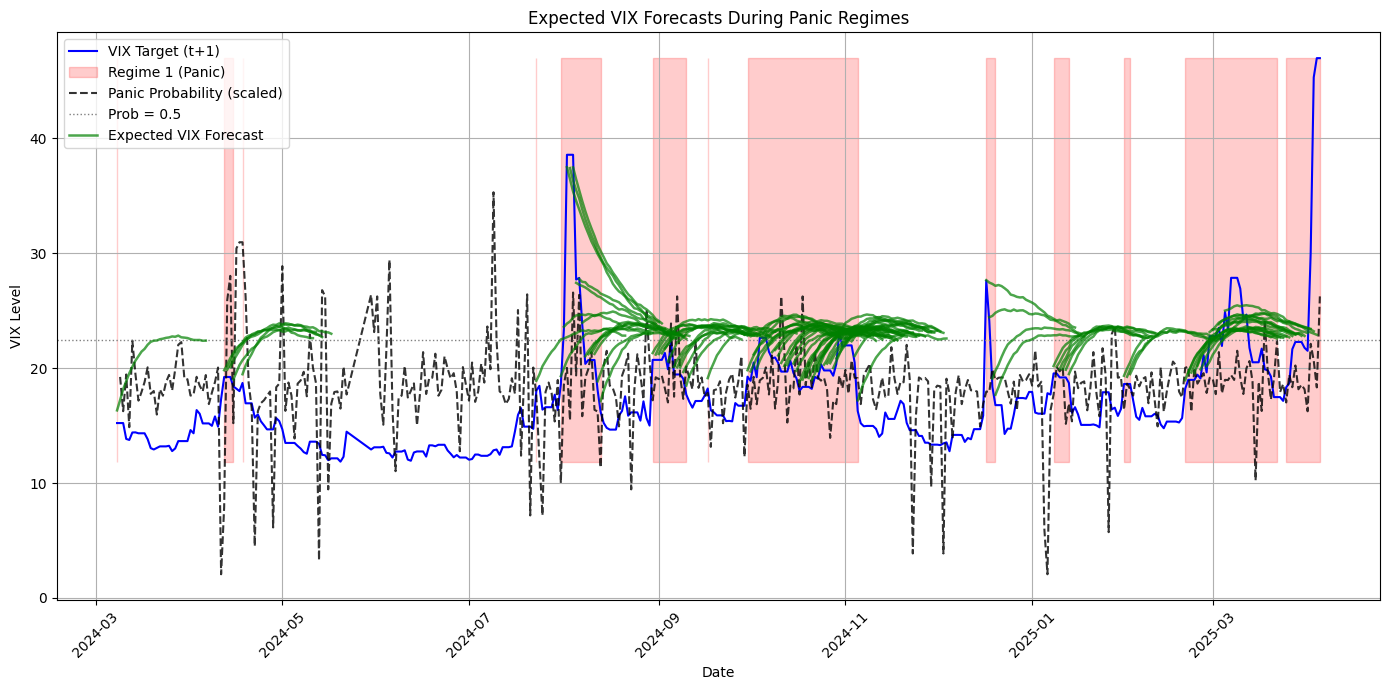

In [394]:
forecast_horizon = 30
expected_paths = []

# Loop through each test point where regime == 1
for idx in range(len(test_df) - forecast_horizon):
    row = test_df.iloc[idx]
    if row['regime_t'] == 1:
        vix_start = row['vix_target_t+1']
        regime_start = row['regime_t']

        # Simulate forecasts from this point
        sim_paths, _ = simulate_vix_paths_ar(
            n_days=forecast_horizon,
            n_paths=1000,
            start_val=vix_start,
            start_regime=regime_start,
            phi_0=phi_0,
            phi_1=phi_1,
            sigma_0=sigma_0,
            sigma_1=sigma_1,
            transition_matrix=transition_matrix_forecast
        )

        # Use expected value (mean forecast) — or replace with np.median(...) if preferred
        expected_path = np.mean(sim_paths, axis=0)

        # Align with index
        future_dates = test_df.index[idx:idx + forecast_horizon]
        if len(future_dates) == forecast_horizon:
            expected_paths.append((future_dates, expected_path))

# === Plot ===
plt.figure(figsize=(14, 7))

# Plot actual VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# Highlight panic regime areas
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# Plot scaled panic probability
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Plot expected forecast paths (mean or median)
for dates, path in expected_paths:
    plt.plot(dates, path, color="green", alpha=0.7, linewidth=1.8, label="Expected VIX Forecast" if 'Expected VIX Forecast' not in plt.gca().get_legend_handles_labels()[1] else "")

# Finalize
plt.title("Expected VIX Forecasts During Panic Regimes")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
